# Setup 

## Libraries 

In [3]:
import matplotlib.pyplot as plt 

# Draw Field 

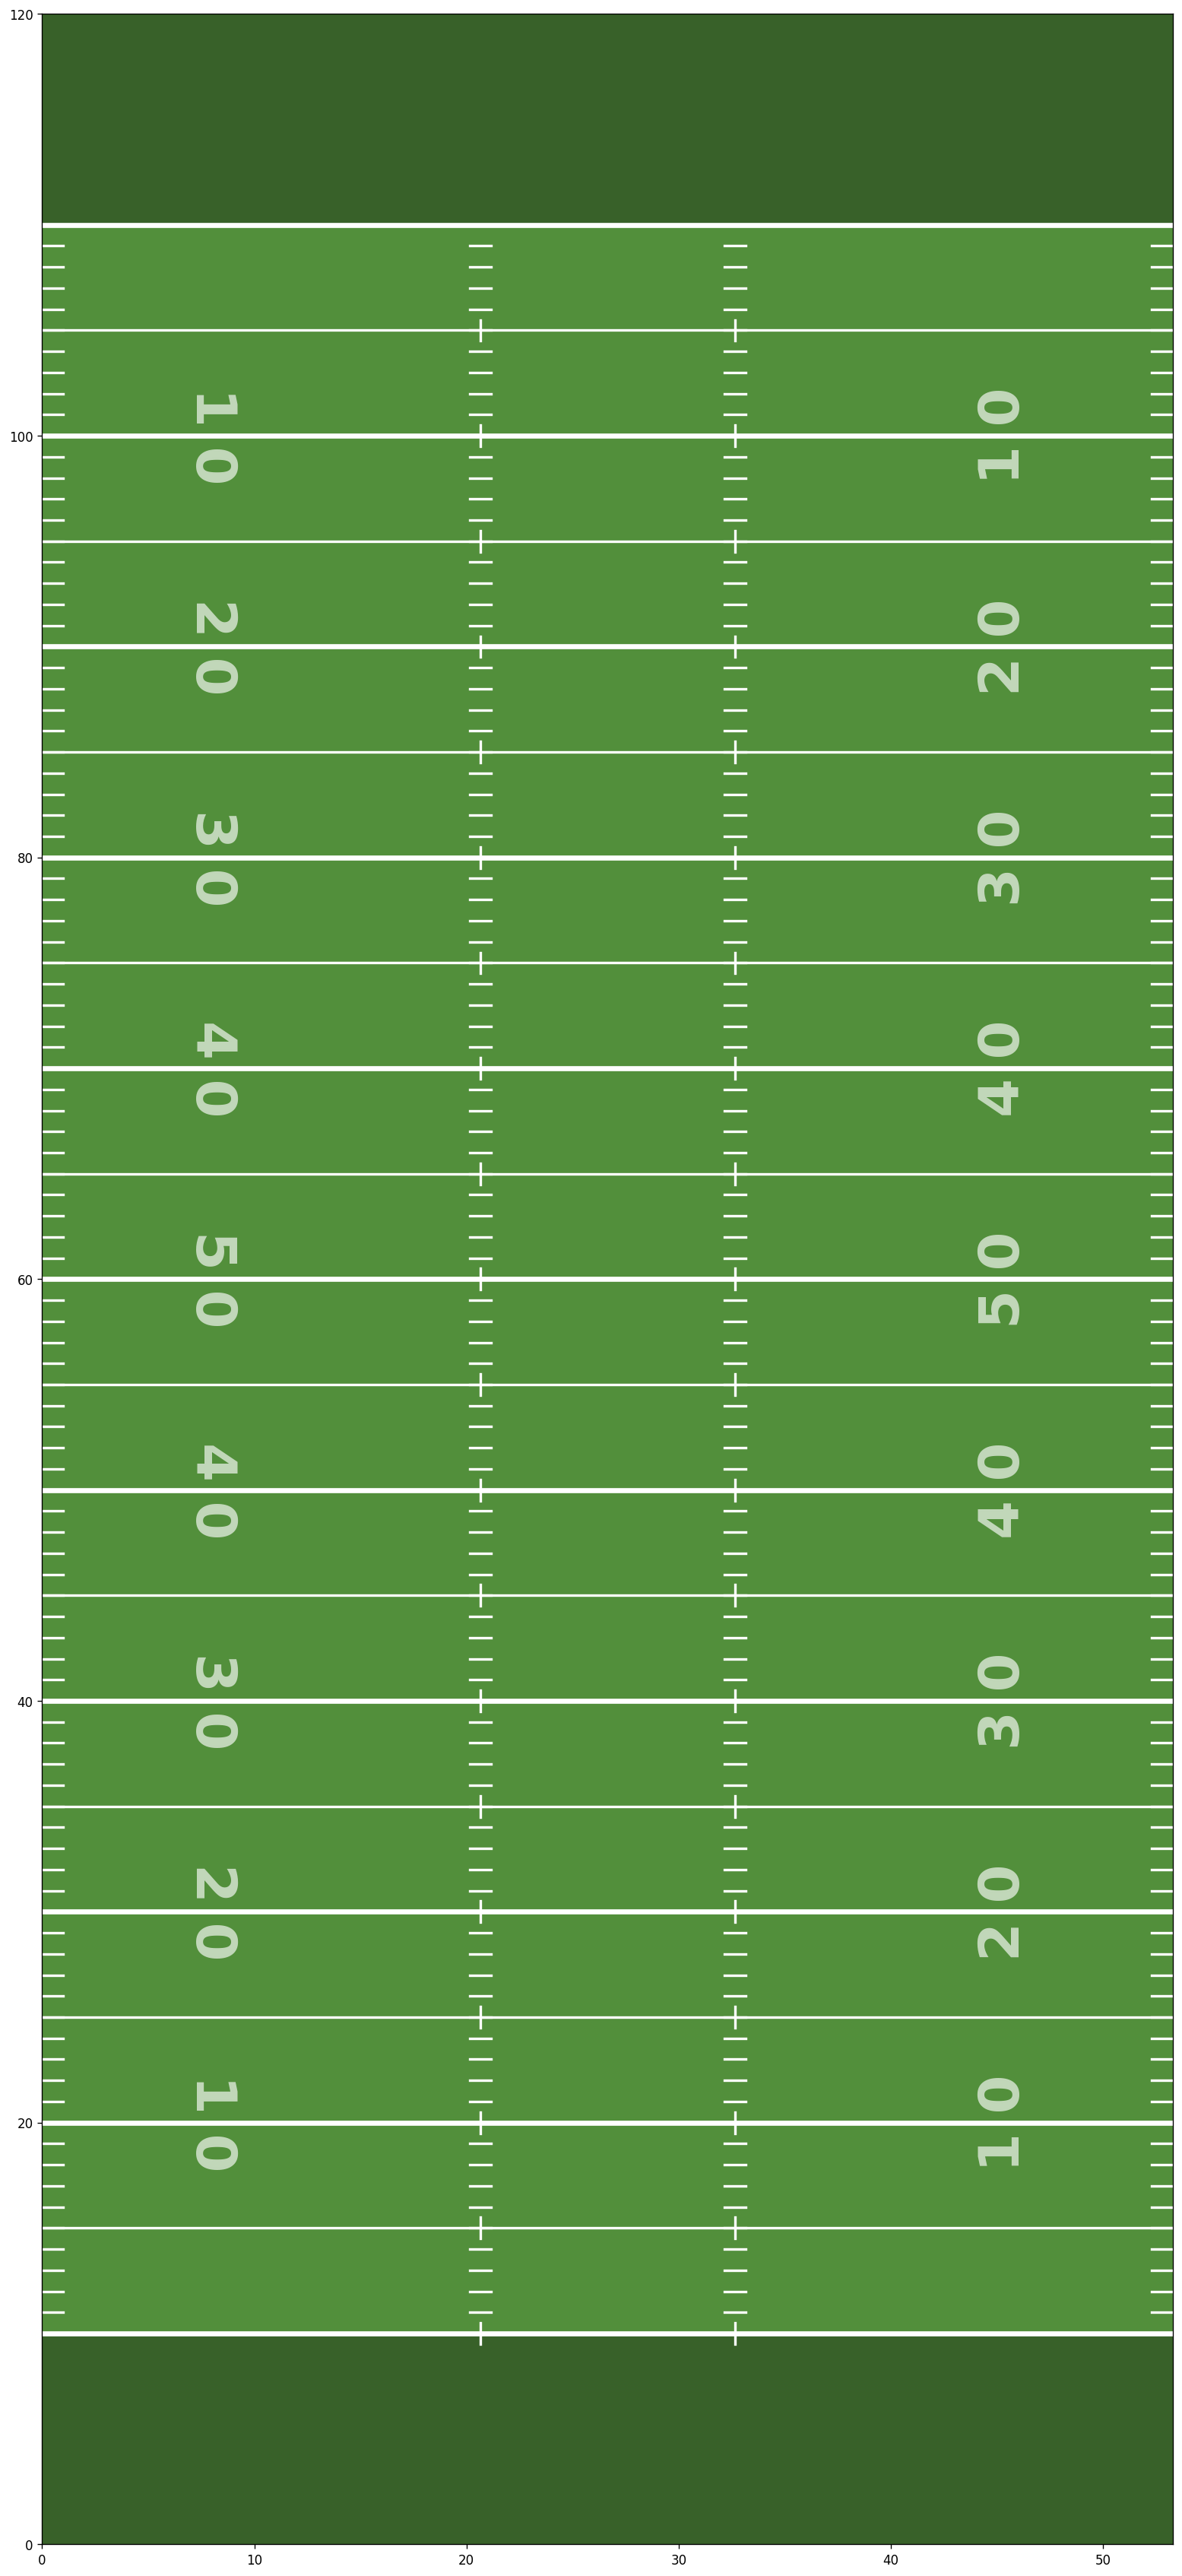

In [ ]:
# class to draw out a football field 
class FootballField:

    def __init__(self, width_pixels = 1920):

        self.height_pixels = int(width_pixels * (120 / 53.3)) # 53.3 yards wide, 120 yards long (including end zones) 
        self.width_pixels = width_pixels 

    def draw(self):

        # create the figure and axis 
        dpi = 120 
        fig, ax = plt.subplots(
            figsize = (self.width_pixels / dpi, self.height_pixels / dpi), 
            dpi = dpi
        ) 

        # Set the background color to green
        ax.set_facecolor((0.32, 0.56, 0.23)) 

        # draw a line for every 5 yards 
        for i in range(0, 21):
            ax.plot(
                [0, 53.3], 
                [10 + (i * 5)] * 2, 
                color = 'white', 
                linewidth = [4, 2][i % 2] 
            ) 
        
        # add the hash marks 
        for x in [20.65, 32.65]: # left and right hash marks 
            for y in range(0, 20):
                yc = (y * 5) + 10 
                ax.plot(
                    [x] * 2, 
                    [yc - 0.5, yc + 0.5], 
                    color = 'white', 
                    linewidth = 2 
                ) 
        
        # add markers for each yard line 
        for x in [0.5, 20.65, 32.65, 52.8]:
            for yl in range(0, 100):
                ax.plot(
                    [x - 0.5, x + 0.5], 
                    [yl + 10] * 2, 
                    color = 'white', 
                    linewidth = 2 
                ) 
        
        # add the numbers 
        for i, txt in enumerate(["1 0", "2 0", "3 0", "4 0", "5 0", "4 0", "3 0", "2 0", "1 0"]):
            for x in [8, 53.3 - 8]:
                ax.text(
                    x = x, 
                    y = (i * 10) + 20, 
                    s = txt, 
                    color = 'white', 
                    fontsize = 44, 
                    fontweight = 'bold', 
                    horizontalalignment = 'center', 
                    verticalalignment = 'center', 
                    rotation = -90 if x < 26.65 else 90, 
                    alpha = 0.65
                ) 
        
        # add rectangles for the endzones 
        for i in [0, 110]:
            ax.add_patch(plt.Rectangle(
                xy = (0, i), 
                height = 10, 
                width = 53.3, 
                color = [0.22, 0.38, 0.16]
            )) 

        # Set limits and remove axes
        ax.set_xlim(0, 53.3)
        ax.set_ylim(0, 120) 

        plt.show() 

ff = FootballField() 
ff.draw() 